# Toepassing Embedding
In het volgende logbook ga ik de gemaakt embedding toepassen op een groot stuk text. Deze text is een combinatie van de engels wikipedia pagina over kanker, verschllende pubmed articles, en een ander article. Eerst wil ik een stuk uitleggen over

Eerst wil ik de data `logs/data/embed_input.txt` inlezen en omzetten naar tokens

In [11]:
from scripts.nlp_jarno import BPETokenizer, Embedder
import pathlib

In [12]:
input = "data/embed_input.txt"


tokenizer = BPETokenizer()
# Duurt **LANG** met 50.000 vandaar de if's
if not pathlib.Path("data/embed_input1.enc").exists():
    tokenizer.generate_enc(input, max_merges=50000, output="data/embed_input1.enc")

Generating corpus and vocab
Starting iteration
Writing enc file to: data/embed_input1.enc


In [13]:
output_tok = pathlib.Path("data/embed_input1.tok")
if not output_tok.exists():
    tokenizer.generate_toc(input, "data/embed_input1.enc", output_tok)

Loading corpus and enc file
Generating tokens
Writing output to: data/embed_input1.tok


Dit gemaakte tok bestand zal gebruikt worden om een embedding te maken via onze embedder class.

In [14]:
embed = Embedder()
embed.embed(output_tok, 3, 100, "data/embed_output.emb")

/home/redman/jaar3/kwartaal2/modelleren/NLP_casusC/.venv/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:785: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Nu is er embedder-file opgeslagen in de data folder. Deze kan gebruikt worden om een pca te maken!

In [15]:
embedding = {}
with open("data/embed_output.emb", 'r') as f:
    for line in f:
        line_split = line.split(" ")
        first = line_split[0].replace("_", " ")
        values = []
        for i in line_split[1:]:
            i = float(i)
            values.append(i)
        embedding[first] = values

In [21]:
import numpy as np
import pandas as pd

vector = np.array(list(embedding.values()))
df = pd.DataFrame(vector)
df["labels"] = list(embedding.keys())
print(df.shape)
df.head()

(20915, 101)


,0,1,2,3,4,5,6,7,8,9,...,91,92,93,94,95,96,97,98,99,labels
0,0.429191,0.016442,-0.264762,0.319474,-0.373945,0.346096,-0.118606,0.081306,-0.434963,-0.029156,...,0.141848,-0.369503,-0.334834,-0.473650,0.144124,0.372609,0.488435,-0.127226,0.292982,
1,-0.167737,-0.120320,-0.134445,-0.151434,-0.157177,-0.151906,-0.172006,-0.142933,-0.166517,-0.167881,...,-0.146786,-0.172025,-0.129900,-0.169081,-0.168625,-0.155740,-0.178996,-0.150060,-0.131095,!
2,-0.173660,-0.134825,-0.146322,-0.132144,-0.168543,-0.172604,-0.178704,-0.149017,-0.150613,-0.169608,...,-0.158830,-0.183128,-0.150567,-0.137712,-0.157258,-0.160977,-0.152397,-0.173312,-0.139781,"!"""
3,-0.144624,-0.144203,-0.143186,-0.143668,-0.164721,-0.145127,-0.174717,-0.159475,-0.152013,-0.155456,...,-0.142883,-0.170799,-0.159426,-0.146594,-0.169631,-0.144241,-0.173281,-0.158624,-0.143065,"!"","
4,-0.169584,-0.150389,-0.135867,-0.152331,-0.145816,-0.149955,-0.161192,-0.156722,-0.160378,-0.163554,...,-0.161284,-0.157363,-0.145670,-0.140824,-0.141854,-0.165378,-0.171565,-0.142790,-0.161164,!'


Deze df is geladen met de embedding en de tokens. Hier kan nu PCA op uitgevoerd worden.

In [22]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt
from adjustText import adjust_text


In [23]:
scaler = StandardScaler()
scaler.fit(vector)
vector_scaled = scaler.transform(vector)
pca = PCA(n_components= 2)
pca_results = pca.fit_transform(vector_scaled)

Nu de PCA uitgevoerd is kan er een masker gemaakt worden van gezochte woorden.


In [36]:
mask = df.iloc[:,-1].isin(["death", "dying", "virus", "Cancer", "Virus", "pain", "oncogenes", "metastasis", "breast cancer", "cell", "gene", "tumor", "tissue", "symptoms", "dying", "chemotherapy", "radiotherapy", "mutations", "diagnosis", "prognosis", "organ", "body", "lymph", ])

filtered_arr = pca_results[mask.values]
filtered_df = df[mask]

x = filtered_arr[:,0]
y = filtered_arr[:,1]



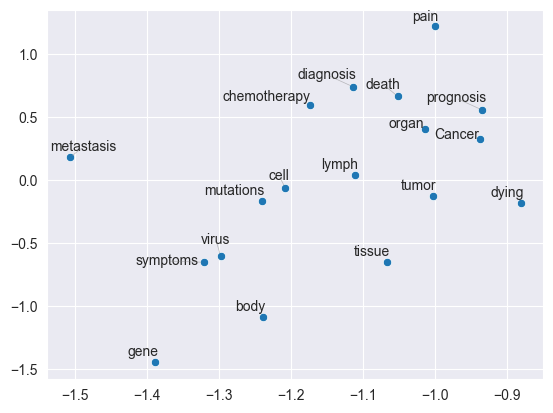

In [37]:
sns.scatterplot(x= x, y= y)
labels = []
for i, label in enumerate(filtered_df["labels"]):
    labels.append(plt.text(x[i], y[i], label, fontsize=10, ha='right', va='bottom'))
adjust_text(labels,
            arrowprops=dict(arrowstyle='-', color='gray', lw=0.5, alpha=0.5),
            force_text=0.5,    # Force between text
            force_points=0.5,  # Force between text and points
            expand_points=(1.5, 1.5),
            expand_text=(1.5, 1.5),
            only_move={'points':'y', 'text':'xy'},
            autoalign='xy',
            precision=0.001)
plt.show();